In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance

import lightgbm as lgb
import glob
import os

### Feature Engineering (Autoencoder)

In [2]:
data_embed = pd.read_csv("wandb_linear_embedding.csv")
data_embed = data_embed.iloc[:20, :]
data_embed = data_embed[[col for col in data_embed.columns if col.endswith('val_loss')]]
data_embed.columns = [f"Embedding_{(8 - i) * 8}" for i in range(data_embed.shape[1])]

In [3]:
data_model = pd.read_csv("wandb_model_comparison.csv")
data_model = data_model.iloc[:20, :]
data_model = data_model[[col for col in data_model.columns if col.endswith('val_loss')]]

data_model_columns = ['cn-lr0001 - val_loss', 'cn-lr0005 - val_loss', 'cn-lr001 - val_loss',
        'conv-lr0001 - val_loss', 'conv-lr0005 - val_loss',
        'conv-lr001 - val_loss', 'linear-lr0001 - val_loss', 'linear-lr0005 - val_loss',
        'linear-lr001 - val_loss']

data_model = data_model[data_model_columns]

data_model.columns = ["CNN_0.001", "CNN_0.005", "CNN_0.01", 
                        "Combined_0.001", "Combined_0.005", "Combined_0.01",
                        "Fully Layer_0.001", "Fully Layer_0.005", "Fully Layer_0.01"]

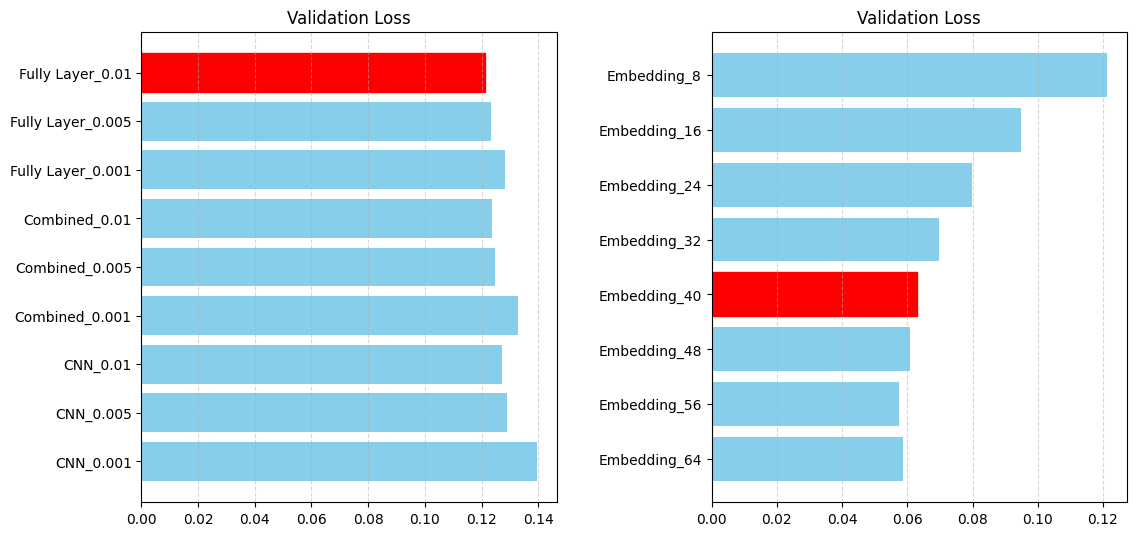

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, ax in enumerate(axes):
    if i == 0:
        bars = ax.barh(data_model.columns, data_model.iloc[19,:], color = "skyblue")
        bars[8].set_color('red') 
    if i == 1:
        bars = ax.barh(data_embed.columns, data_embed.iloc[19,:], color = "skyblue")
        bars[3].set_color('red') 

    ax.set_title('Validation Loss')

    ax.xaxis.grid(True, linestyle='--', alpha=0.5)


plt.tight_layout(pad=3.0)
plt.show()

### CART Modeling

In [5]:
# Read the CSV file
all_files = glob.glob("../data/data_with_features_and_pca/*.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Display the first few rows of the dataframe
df.head()

,image_id,y,x,NDAI,SD,CORR,DF,CF,BF,AF,...,ae30,ae31,ae32,ae33,ae34,ae35,ae36,ae37,ae38,ae39
0,O013490.npz,289.0,133.0,0.172480,2114.592285,0.402172,26389.00,23415.00,21986.50,21103.75,...,-1.412890,0.669047,-0.399436,0.466629,-3.686194,1.237506,1.569268,-1.303340,-0.079690,0.048487
1,O013490.npz,289.0,134.0,0.189369,1517.232300,0.475867,26268.25,23103.00,21264.25,19433.00,...,-1.209435,0.221109,-0.897648,0.269087,-3.525530,0.506501,1.004309,-0.924130,0.364213,-0.023495
2,O013490.npz,289.0,135.0,0.204767,1770.846191,0.430038,30330.75,25545.75,21995.50,20701.50,...,-0.953039,-0.344724,-1.393905,-0.059773,-3.519139,0.783280,0.285509,-0.264954,0.789590,-0.168808
3,O013490.npz,289.0,136.0,0.195127,2089.162842,0.604003,30077.75,26168.00,23087.00,21160.25,...,-0.432796,-0.290007,-2.511081,-0.599821,-3.346292,0.903113,-0.636943,0.197252,0.826215,0.327441
4,O013490.npz,289.0,137.0,0.162103,1693.682251,0.704407,28455.25,24712.25,22929.50,21504.50,...,-0.022318,-0.578921,-2.734356,-1.301599,-3.596317,1.068354,-0.628633,0.154284,1.075065,0.627367


In [6]:
def assign_quadrants(df):
    # Compute medians for each image
    medians = df.groupby('image_id')[['x', 'y']].median().rename(columns={'x': 'median_x', 'y': 'median_y'})
    df = df.merge(medians, left_on='image_id', right_index=True, how='left')
    
    # Assign quadrant based on image-specific medians
    def get_q(row):
        if row['x'] <= row['median_x'] and row['y'] <= row['median_y']:
            return 'Q1'
        elif row['x'] > row['median_x'] and row['y'] <= row['median_y']:
            return 'Q2'
        elif row['x'] <= row['median_x'] and row['y'] > row['median_y']:
            return 'Q3'
        else:
            return 'Q4'
    
    df['quadrant'] = df.apply(get_q, axis=1)
    df.drop(columns=['median_x', 'median_y'], inplace=True)
    return df

In [7]:
df_train = df[(df["image_id"] == "O012791.npz") | (df["image_id"] == "O013257.npz")]
df_test = df[df["image_id"] == "O013490.npz"]

df_train = assign_quadrants(df_train)
df_train_filtered = df_train[df_train['expert_label'] != 0]

df_train = df_train.drop(columns=["image_id", "y", "x"])
df_test = df_test.drop(columns=["image_id", "y", "x"])

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.99      0.91      0.95     42830
         1.0       0.91      0.99      0.95     39253

    accuracy                           0.95     82083
   macro avg       0.95      0.95      0.95     82083
weighted avg       0.95      0.95      0.95     82083



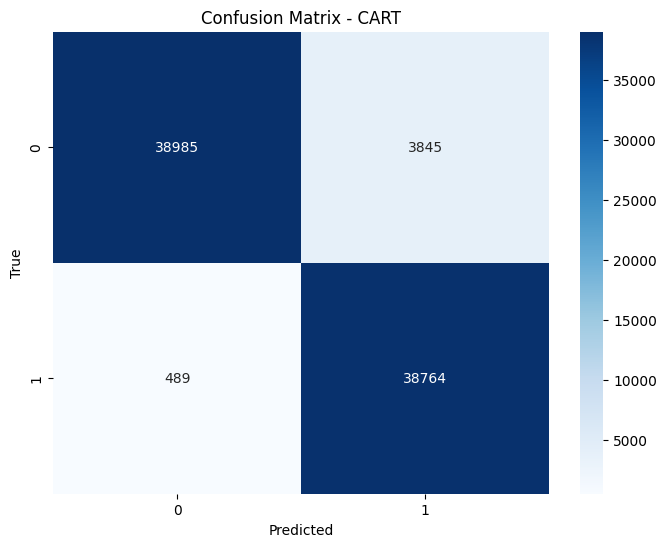

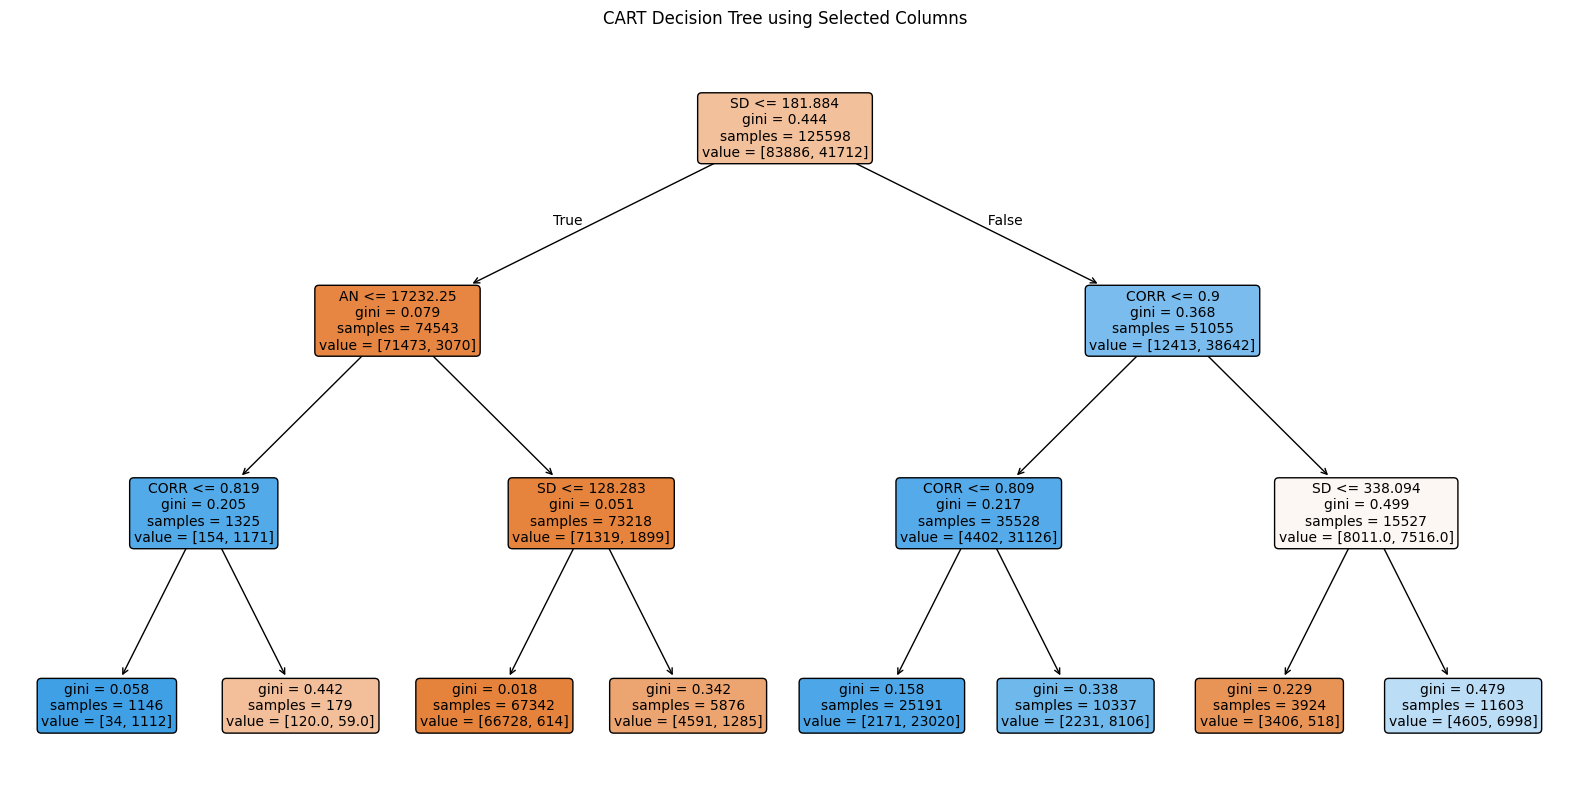

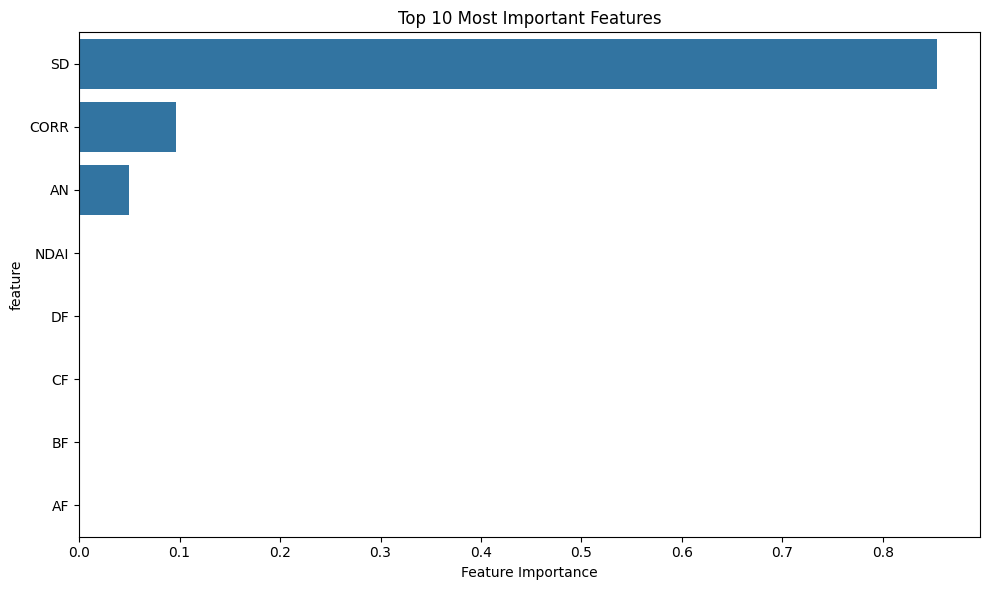

In [8]:
# Cart with old features
df_train_filtered = df_train[df_train['expert_label'] != 0]
df_test_filtered = df_test[df_test['expert_label'] != 0]

X_train = df_train_filtered[["NDAI", "SD", "CORR", "DF", "CF", "BF", "AF", "AN"]]
y_train = df_train_filtered["expert_label"]

X_test = df_test_filtered[["NDAI", "SD", "CORR", "DF", "CF", "BF", "AF", "AN"]]
y_test = df_test_filtered["expert_label"]

cart_model = DecisionTreeClassifier(random_state=42, max_depth=3)
cart_model.fit(X_train, y_train)

y_pred = cart_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_small = cm

plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix - CART")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(cart_model, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("CART Decision Tree using Selected Columns")
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': cart_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      0.98      0.99     42830
         1.0       0.98      1.00      0.99     39253

    accuracy                           0.99     82083
   macro avg       0.99      0.99      0.99     82083
weighted avg       0.99      0.99      0.99     82083



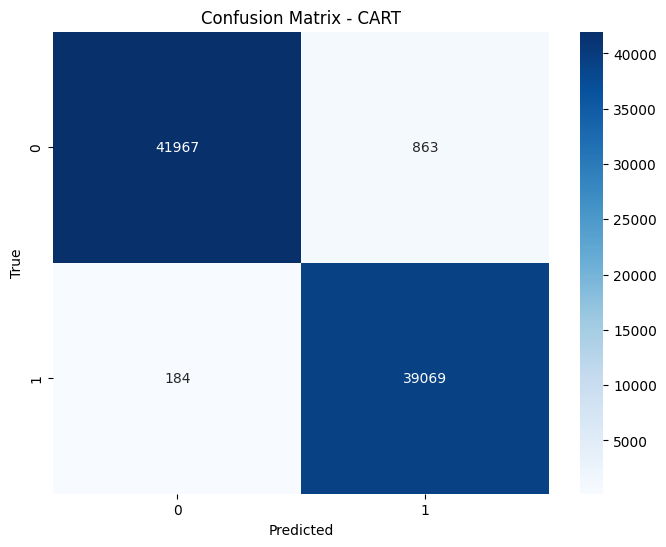

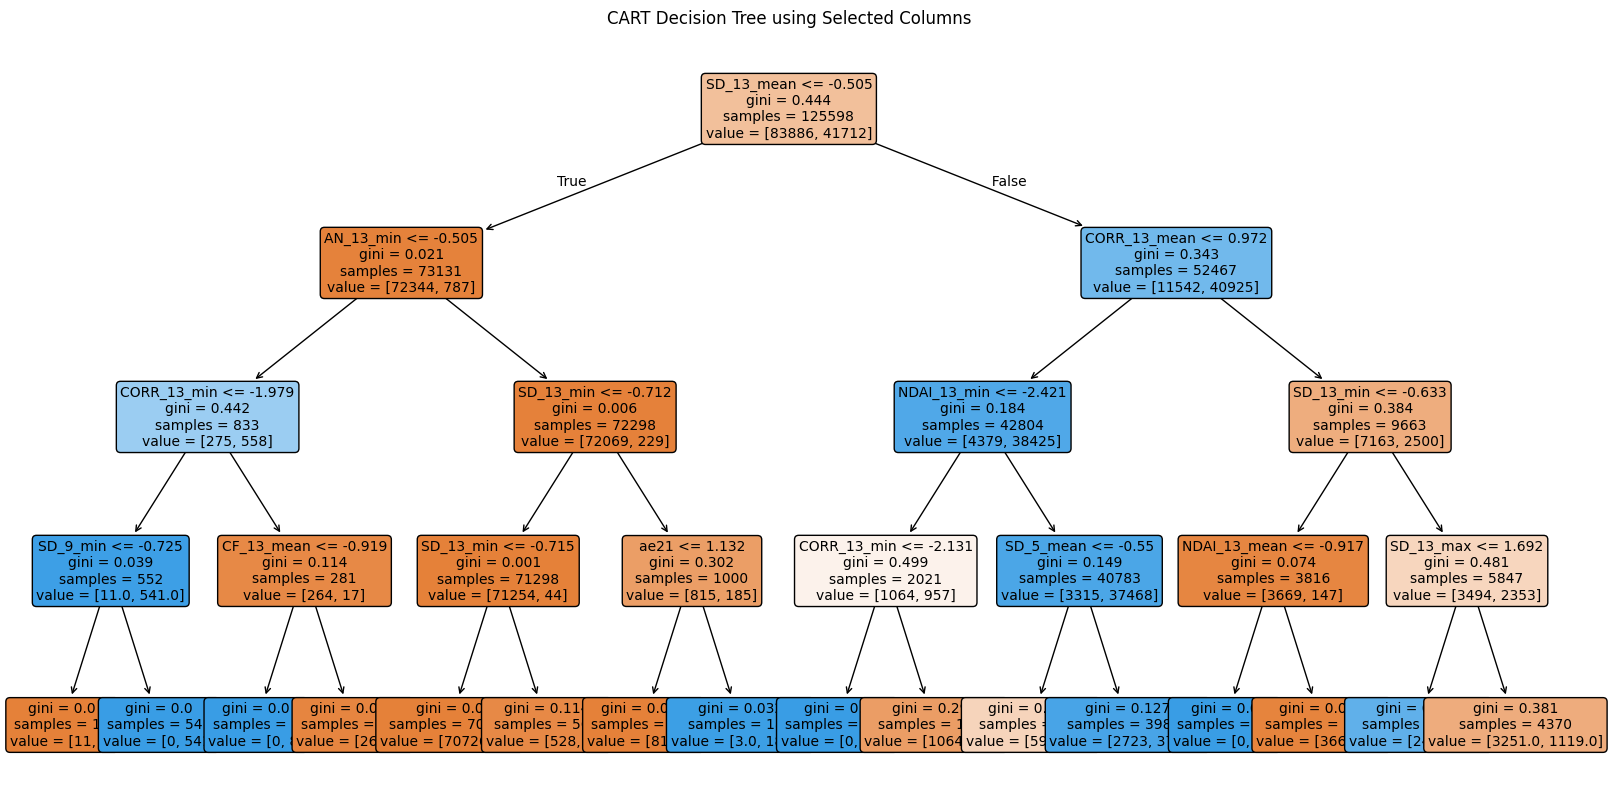

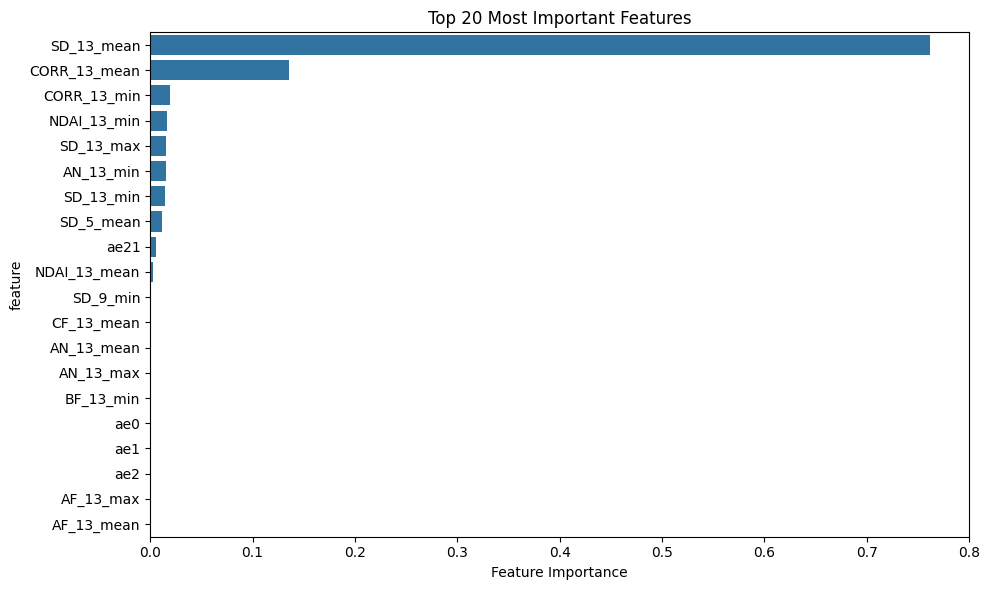

In [9]:
# Cart with all new features
df_train_filtered = df_train[df_train['expert_label'] != 0]
df_test_filtered = df_test[df_test['expert_label'] != 0]

X_train = df_train_filtered.drop(['expert_label', 'quadrant'], axis = 1)
y_train = df_train_filtered["expert_label"]

X_test = df_test_filtered.drop(['expert_label'], axis = 1)
y_test = df_test_filtered["expert_label"]

cart_model = DecisionTreeClassifier(random_state=42, max_depth=4)
cart_model.fit(X_train, y_train)

y_pred = cart_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix - CART")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(cart_model, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title("CART Decision Tree using Selected Columns")
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': cart_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ........................................max_depth=4; total time=   6.4s
[CV] END ........................................max_depth=4; total time=   6.4s
[CV] END ........................................max_depth=4; total time=   6.8s
[CV] END ........................................max_depth=4; total time=   7.1s
[CV] END .....................................max_depth=None; total time=  10.1s
[CV] END .....................................max_depth=None; total time=  12.6s
[CV] END .....................................max_depth=None; total time=  14.2s
[CV] END .....................................max_depth=None; total time=  18.1s
Best Parameters: {'max_depth': 4}
Best CV Score: 0.8958492218878982

Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      0.98      0.99     42830
         1.0       0.98      1.00      0.99     39253

    accuracy                         

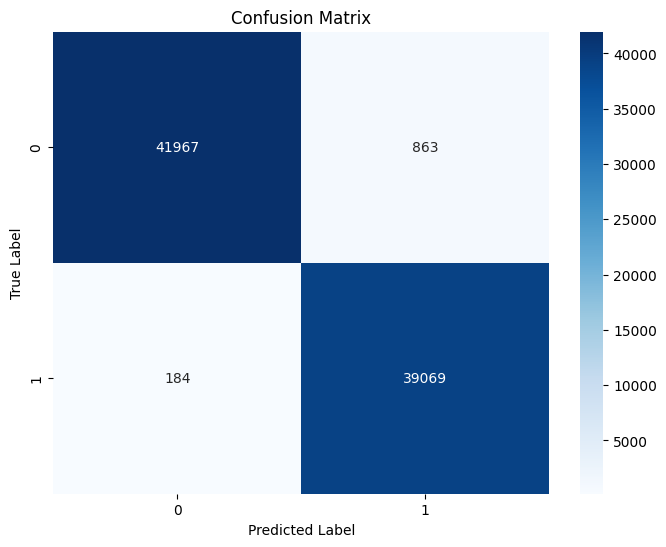

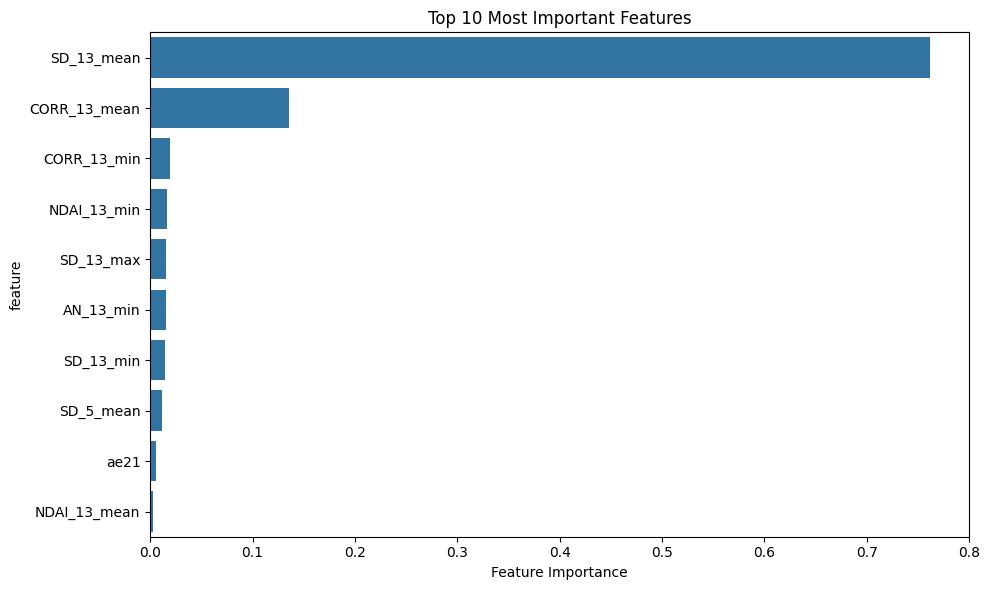

In [10]:

df_train_filtered = df_train[df_train['expert_label'] != 0]
df_test_filtered = df_test[df_test['expert_label'] != 0]

# Save the grouping column for cross-validation
groups = df_train_filtered["quadrant"]
gkf = GroupKFold(n_splits=len(df_train_filtered['quadrant'].unique()))

X_train = df_train_filtered.drop(['expert_label', 'quadrant'], axis=1)
y_train = df_train_filtered["expert_label"]

X_test = df_test_filtered.drop(['expert_label'], axis=1)
y_test = df_test_filtered["expert_label"]

param_grid = {
    'max_depth': [None, 4],
}

rf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=gkf, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train, groups=groups)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


### Random Forest

In [11]:
#Hyperparameer Search --> You need out comment the code to run it
"""
    df_train_filtered = df_train[df_train['expert_label'] != 0]
    df_test_filtered = df_test[df_test['expert_label'] != 0]

    # Save the grouping column for cross-validation
    groups = df_train_filtered["quadrant"]
    gkf = GroupKFold(n_splits=len(df_train_filtered['quadrant'].unique()))

    X_train = df_train_filtered.drop(['expert_label', 'quadrant'], axis=1)
    y_train = df_train_filtered["expert_label"]

    X_test = df_test_filtered.drop(['expert_label'], axis=1)
    y_test = df_test_filtered["expert_label"]

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50 ,100, 200],
        'max_depth': [None, 4, 5, 6],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
    }

    rf = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=gkf, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train, groups=groups)

    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score:", grid_search.best_score_)

    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()"
"""


'\n    df_train_filtered = df_train[df_train[\'expert_label\'] != 0]\n    df_test_filtered = df_test[df_test[\'expert_label\'] != 0]\n\n    # Save the grouping column for cross-validation\n    groups = df_train_filtered["quadrant"]\n    gkf = GroupKFold(n_splits=len(df_train_filtered[\'quadrant\'].unique()))\n\n    X_train = df_train_filtered.drop([\'expert_label\', \'quadrant\'], axis=1)\n    y_train = df_train_filtered["expert_label"]\n\n    X_test = df_test_filtered.drop([\'expert_label\'], axis=1)\n    y_test = df_test_filtered["expert_label"]\n\n    # Define the parameter grid for hyperparameter tuning\n    param_grid = {\n        \'n_estimators\': [50 ,100, 200],\n        \'max_depth\': [None, 4, 5, 6],\n        \'min_samples_split\': [2, 5],\n        \'min_samples_leaf\': [1, 2, 4],\n    }\n\n    rf = RandomForestClassifier(random_state=42)\n\n    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=gkf, n_jobs=-1, verbose=2)\n    grid_search.fit(X_train, y_train, 


Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      0.97      0.98     42830
         1.0       0.97      0.99      0.98     39253

    accuracy                           0.98     82083
   macro avg       0.98      0.98      0.98     82083
weighted avg       0.98      0.98      0.98     82083



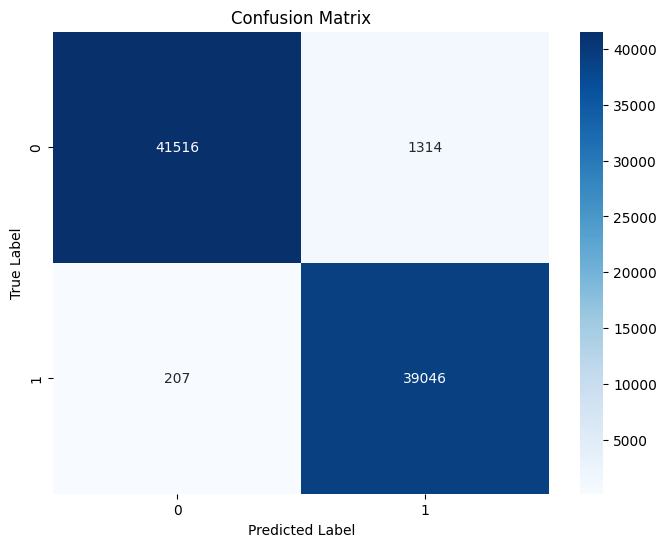

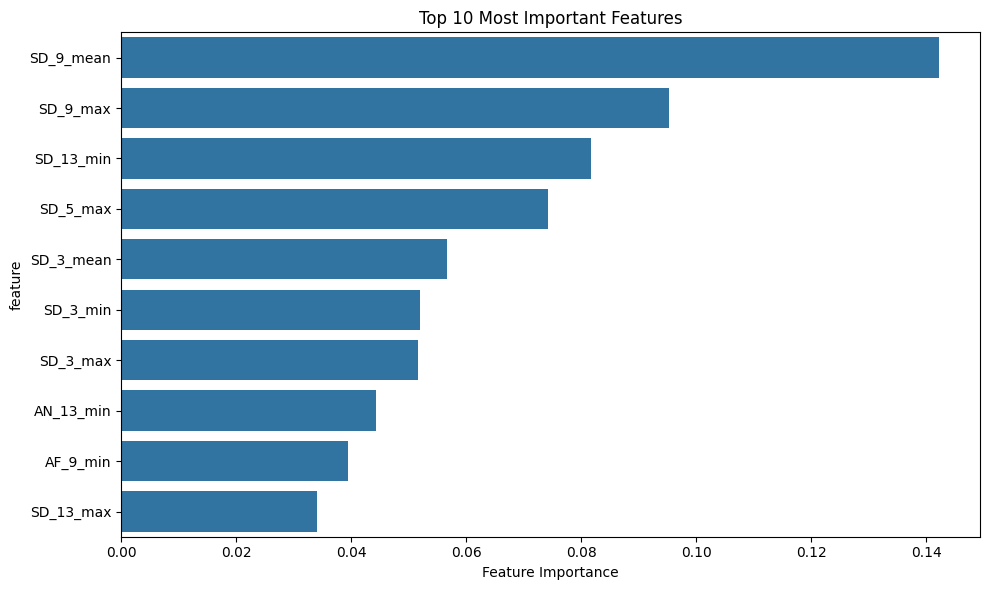

In [12]:
df_train_filtered = df_train[df_train['expert_label'] != 0]
df_test_filtered = df_test[df_test['expert_label'] != 0]

X_train = df_train_filtered.drop(['expert_label', 'quadrant'], axis=1)
y_train = df_train_filtered["expert_label"]

X_test = df_test_filtered.drop(['expert_label'], axis=1)
y_test = df_test_filtered["expert_label"]

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators = 30, max_depth = 4,  random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
cm_rf = cm
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [13]:
wrapped_params = {
    'n_estimators': [20],
    'max_depth': [4],
}

grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=wrapped_params,
                           cv=gkf,  # use GroupKFold here
                           n_jobs=-1,
                           verbose=1,
                           scoring='accuracy')
grid_search.fit(X_train, y_train, groups=groups)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_scores_rf = cv_results.filter(like="split", axis=1)
print(cv_scores_rf)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
   split0_test_score  split1_test_score  split2_test_score  split3_test_score
0           0.890517           0.705984           0.999317           0.817694


### KNN

In [14]:
scaler = StandardScaler()
X_train_k = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_k = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1,10)}

groups = df_train_filtered['quadrant']
gkf = GroupKFold(n_splits=len(df_train_filtered['quadrant'].unique()))

grid_search = GridSearchCV(estimator=knn, 
                        param_grid=param_grid, 
                        cv=gkf,  # use GroupKFold here
                        n_jobs=-1, 
                        verbose=1)

grid_search.fit(X_train_k, y_train, groups=groups)
print("Best Parameters:", grid_search.best_params_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/Users/taiki/Desktop/cal_venv/cal/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_neighbors': 2}


In [15]:
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_k)
cm_knn = confusion_matrix(y_test, y_pred_knn)

In [16]:
wrapped_params = {k: [v] for k, v in grid_search.best_params_.items()}
wrapped_params
grid_search = GridSearchCV(estimator=knn, 
                           param_grid=wrapped_params,
                           cv=gkf,  # use GroupKFold here
                           n_jobs=-1,
                           verbose=1,
                           scoring='accuracy')
grid_search.fit(X_train, y_train, groups=groups)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_scores_knn = cv_results.filter(like="split", axis=1)
print(cv_scores_knn)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
   split0_test_score  split1_test_score  split2_test_score  split3_test_score
0           0.755198           0.828784           0.829307           0.645688


### LightGBM

In [17]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.05, 0.1, 0.15]
}

lgbm = lgb.LGBMClassifier(objective='binary', metric='accuracy', boosting_type='gbrt', verbose=-1)

groups = df_train_filtered['quadrant']
gkf = GroupKFold(n_splits=len(df_train_filtered['quadrant'].unique()))

# Set up GridSearchCV with the custom group split
grid_search = GridSearchCV(estimator=lgbm, 
                           param_grid=param_grid, 
                           cv=gkf,  # use GroupKFold here
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train, groups=groups)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_:.4f}")

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/Users/taiki/Desktop/cal_venv/cal/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.15, 'num_leaves': 31}
Best AUC score: 0.9318


In [18]:
best_params = grid_search.best_params_

params_lgb = {
    'objective': 'binary',
    'metric': 'accuracy',
    'boosting_type': 'gbrt',
    'verbose': -1,
}

params_lgb.update(best_params)

params_lgb

{'objective': 'binary',
 'metric': 'accuracy',
 'boosting_type': 'gbrt',
 'verbose': -1,
 'learning_rate': 0.15,
 'num_leaves': 31}

In [19]:
evals_result = {}

lgb_best_model = lgb.LGBMClassifier(**params_lgb, n_estimators=1000)

lgb_best_model.fit(X_train[df_train_filtered["quadrant"] != "Q4"], 
                   y_train[df_train_filtered["quadrant"] != "Q4"], 
        eval_set=[(X_train[df_train_filtered["quadrant"] == "Q4"], 
                   y_train[df_train_filtered["quadrant"] == "Q4"])], 
        eval_metric= "binary_error",
        callbacks=[lgb.log_evaluation(period=50),
                    lgb.record_evaluation(evals_result)])

y_pred_prob = lgb_best_model.predict(X_test)

y_pred_lgb = (y_pred_prob > 0.5).astype(int)
y_pred_lgb[y_pred_lgb == 0] = -1

cm_lgb = confusion_matrix(y_test, y_pred_lgb)

[50]	valid_0's binary_error: 0.00308873
[100]	valid_0's binary_error: 0.0037715
[150]	valid_0's binary_error: 0.00419417
[200]	valid_0's binary_error: 0.00315375
[250]	valid_0's binary_error: 0.00279611
[300]	valid_0's binary_error: 0.00289365
[350]	valid_0's binary_error: 0.00282862
[400]	valid_0's binary_error: 0.00279611
[450]	valid_0's binary_error: 0.00282862
[500]	valid_0's binary_error: 0.00282862
[550]	valid_0's binary_error: 0.00282862
[600]	valid_0's binary_error: 0.00289365
[650]	valid_0's binary_error: 0.0027636
[700]	valid_0's binary_error: 0.00273109
[750]	valid_0's binary_error: 0.00266606
[800]	valid_0's binary_error: 0.00266606
[850]	valid_0's binary_error: 0.00269857
[900]	valid_0's binary_error: 0.00266606
[950]	valid_0's binary_error: 0.00266606
[1000]	valid_0's binary_error: 0.00266606


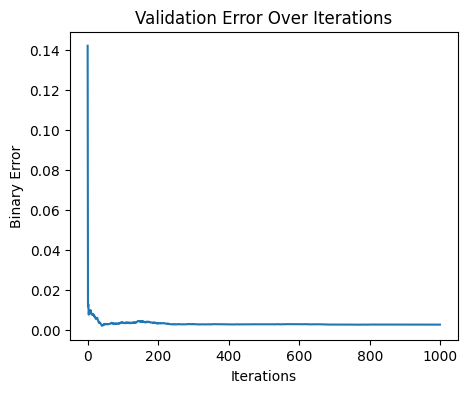

In [20]:
plt.figure(figsize=(5, 4))
plt.plot(evals_result["valid_0"]["binary_error"], label="Validation Binary Error")
plt.xlabel("Iterations")
plt.ylabel("Binary Error")
plt.title("Validation Error Over Iterations")
plt.show()

In [21]:
X_train

,NDAI,SD,CORR,DF,CF,BF,AF,AN,NDAI_3_min,NDAI_3_mean,...,ae30,ae31,ae32,ae33,ae34,ae35,ae36,ae37,ae38,ae39
28751,0.593831,1169.416504,0.473416,23461.00,18388.50,11575.25,8993.25,5978.75,3.490213,4.039388,...,4.803157,-4.026411,-6.326554,-0.315492,2.649065,-2.264119,-3.279856,-7.516905,-0.587625,4.115249
28752,0.550953,1376.460571,0.861363,23831.75,16752.50,12560.25,9570.75,6900.00,3.715380,4.025503,...,3.870697,-5.317784,-1.153739,0.652757,3.595841,1.379685,2.294013,-7.116533,0.163188,5.385777
28753,0.550160,1389.984863,0.687417,23185.75,15590.75,14639.50,8372.50,6728.25,3.715380,3.953891,...,3.194242,-6.948358,1.641537,0.840933,0.687790,1.146147,-0.377587,-7.456187,5.033743,2.959802
28754,0.615813,1388.641357,0.486022,23047.75,16095.25,12771.50,7136.00,5480.00,3.715380,4.074224,...,1.806325,-2.623356,-1.394290,0.640418,-3.656365,1.560382,-1.317234,-5.919602,0.814251,0.519568
28755,0.599688,1648.248657,0.766353,23816.75,16542.50,11906.00,6817.25,5960.00,4.038754,4.400455,...,2.227911,-2.494785,-2.907555,1.193003,-3.164257,2.105986,-2.462286,-4.844177,-0.296781,1.246159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344880,0.106347,430.340271,0.879663,30853.25,30061.25,29045.50,26993.50,24921.75,-0.998409,-0.895430,...,-1.555709,1.827682,-2.565747,0.757634,0.260674,1.595380,-0.682367,0.326351,-0.861415,0.800733
344881,0.102585,670.935730,0.917750,31642.25,31268.00,29899.75,27760.25,25754.25,-0.979068,-0.912026,...,-1.779451,2.210242,-2.700586,0.320109,-0.377765,1.876510,-1.434634,0.914028,-0.627416,-0.011144
344882,0.096270,690.928284,0.923715,32391.75,32050.50,30724.75,28935.50,26702.75,-0.979068,-0.927967,...,-1.655791,2.376984,-2.633559,-0.101860,-0.634832,1.613825,-0.420108,0.578915,-0.187119,-0.535503
344883,0.102834,395.994690,0.809468,32723.00,32930.75,31366.75,29269.00,26620.50,-0.978151,-0.844232,...,-1.369434,2.822794,-2.209183,-0.234142,-0.478384,1.380847,1.382565,-0.004305,-0.429462,-0.681445


### LightGBM: Feature Selections

In [22]:
X_train_selected = X_train[df_train_filtered["quadrant"] != "Q4"]
y_train_selected = y_train[df_train_filtered["quadrant"] != "Q4"]
X_eval_selected = X_train[df_train_filtered["quadrant"] == "Q4"]
y_eval_selected = y_train[df_train_filtered["quadrant"] == "Q4"]
X_test_selected = X_test

X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("AF_", case=True)]
X_eval_selected = X_eval_selected.loc[:, ~X_eval_selected.columns.str.contains("AF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("BF_", case=True)]
X_eval_selected = X_eval_selected.loc[:, ~X_eval_selected.columns.str.contains("BF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("CF_", case=True)]
X_eval_selected = X_eval_selected.loc[:, ~X_eval_selected.columns.str.contains("CF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("AN_", case=True)]
X_eval_selected = X_eval_selected.loc[:, ~X_eval_selected.columns.str.contains("AN_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("DF_", case=True)]
X_eval_selected = X_eval_selected.loc[:, ~X_eval_selected.columns.str.contains("DF_", case=True)]

X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("AF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("BF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("CF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("DF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("AN_", case=True)]

In [23]:
lgb_best_model_selected = lgb.LGBMClassifier(**params_lgb, n_estimators=1000)
lgb_best_model_selected.fit(X_train_selected, y_train_selected,
        eval_set=[(X_eval_selected, y_eval_selected)], 
        eval_metric= "binary_error",
        callbacks=[lgb.log_evaluation(period=50),
                    lgb.record_evaluation(evals_result)])

y_pred_prob_selected = lgb_best_model_selected.predict(X_test_selected)

y_pred_lgb_selected = (y_pred_prob_selected > 0.5).astype(int)
y_pred_lgb_selected[y_pred_lgb_selected == 0] = -1

cm_lgb = confusion_matrix(y_test, y_pred_lgb_selected)
(cm_lgb[0, 0] + cm_lgb[1, 1]) / cm_lgb.sum()

[50]	valid_0's binary_error: 0.00341386
[100]	valid_0's binary_error: 0.00347888
[150]	valid_0's binary_error: 0.00370647
[200]	valid_0's binary_error: 0.00334883
[250]	valid_0's binary_error: 0.00325129
[300]	valid_0's binary_error: 0.00328381
[350]	valid_0's binary_error: 0.00315375
[400]	valid_0's binary_error: 0.00312124
[450]	valid_0's binary_error: 0.00308873
[500]	valid_0's binary_error: 0.0030237
[550]	valid_0's binary_error: 0.0030237
[600]	valid_0's binary_error: 0.00305621
[650]	valid_0's binary_error: 0.00299119
[700]	valid_0's binary_error: 0.0030237
[750]	valid_0's binary_error: 0.00305621
[800]	valid_0's binary_error: 0.00308873
[850]	valid_0's binary_error: 0.00305621
[900]	valid_0's binary_error: 0.0030237
[950]	valid_0's binary_error: 0.0030237
[1000]	valid_0's binary_error: 0.00299119


0.9874273601111071

### Acurracy Comparison

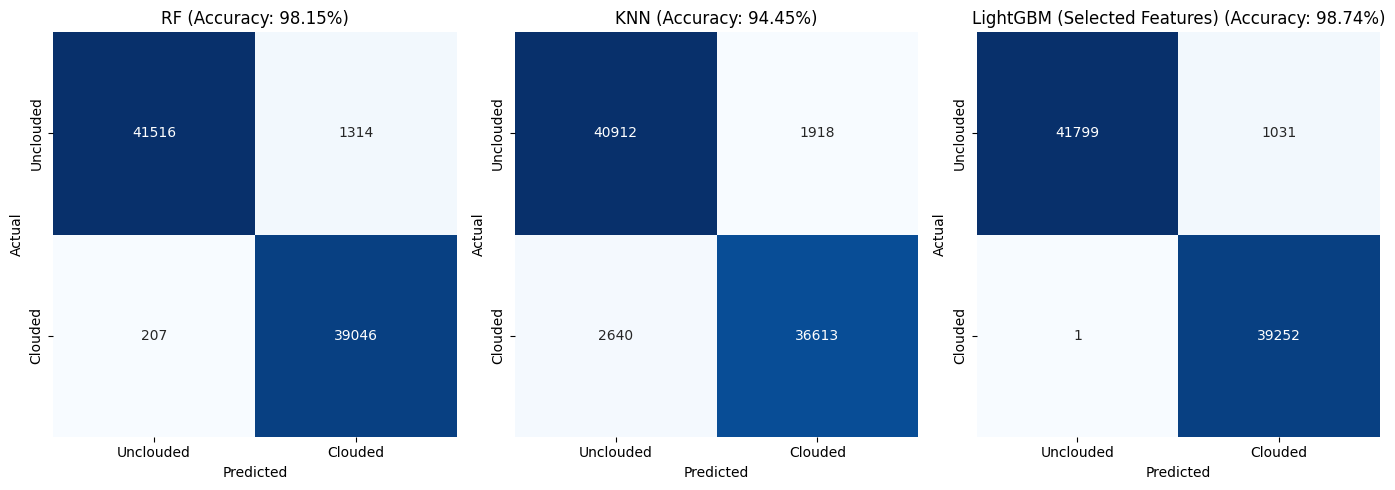

In [24]:
titles = ["RF", "KNN", "LightGBM (Selected Features)"]
cm_list = [cm_rf, cm_knn, cm_lgb]

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for i, ax in enumerate(axes.flat):
    accuracy = (cm_list[i][0, 0] + cm_list[i][1, 1]) / cm_list[i].sum()
    sns.heatmap(cm_list[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Unclouded", "Clouded"], 
                yticklabels=["Unclouded", "Clouded"],
                ax=ax, cbar=False)
    ax.set_title(f"{titles[i]} (Accuracy: {accuracy:.2%})")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [25]:
X_train_selected = X_train.copy()
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("AF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("BF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("CF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("DF_", case=True)]
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.str.contains("AN_", case=True)]

X_test_selected = X_test.copy()
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("AF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("BF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("CF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("DF_", case=True)]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.str.contains("AN_", case=True)]

In [26]:
wrapped_params = {k: [v] for k, v in params_lgb.items()}
grid_search = GridSearchCV(estimator=lgbm, 
                           param_grid=wrapped_params,
                           cv=gkf,  # use GroupKFold here
                           n_jobs=-1,
                           verbose=1,
                           scoring='accuracy')
grid_search.fit(X_train_selected, y_train, groups=groups)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_scores_lgb = cv_results.filter(like="split", axis=1)
print(cv_scores_lgb)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
   split0_test_score  split1_test_score  split2_test_score  split3_test_score
0           0.941938           0.957534           0.996521           0.864294


In [27]:
# Compare 4_fold CV scores
print(cv_scores_rf)
print(cv_scores_knn)
print(cv_scores_lgb)

   split0_test_score  split1_test_score  split2_test_score  split3_test_score
0           0.890517           0.705984           0.999317           0.817694
   split0_test_score  split1_test_score  split2_test_score  split3_test_score
0           0.755198           0.828784           0.829307           0.645688
   split0_test_score  split1_test_score  split2_test_score  split3_test_score
0           0.941938           0.957534           0.996521           0.864294


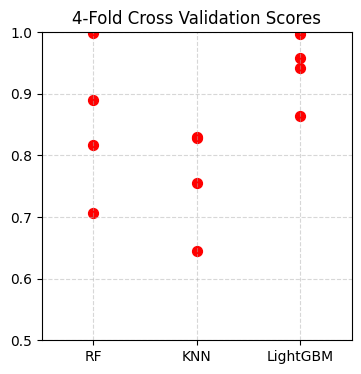

In [28]:
cv_scores_list = [cv_scores_rf, cv_scores_knn, cv_scores_lgb]
label = ["RF", "KNN", "LightGBM"]

plt.figure(figsize=(4, 4))

for i in range(3):
    for j in range(4):
        plt.scatter(i, cv_scores_list[i].iloc[0, j], label = label[i], s = 50, color = "red")

plt.xticks(np.linspace(0, 2, 3), [label[i] for i in range(3)])
plt.xlim(-0.5, 2.5)
plt.ylim(0.5, 1)
plt.title("4-Fold Cross Validation Scores")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 4-3 Pick a good classifier. Show some diagnostic plots or information related to convergence, parameter estimation (depending on your choice of models), and feature importance. The last item will be especially interesting after all of our effort spent engineering good features. Some examples of useful techniques are MDI+, coefficient magnitudes, permutation importance, etc.

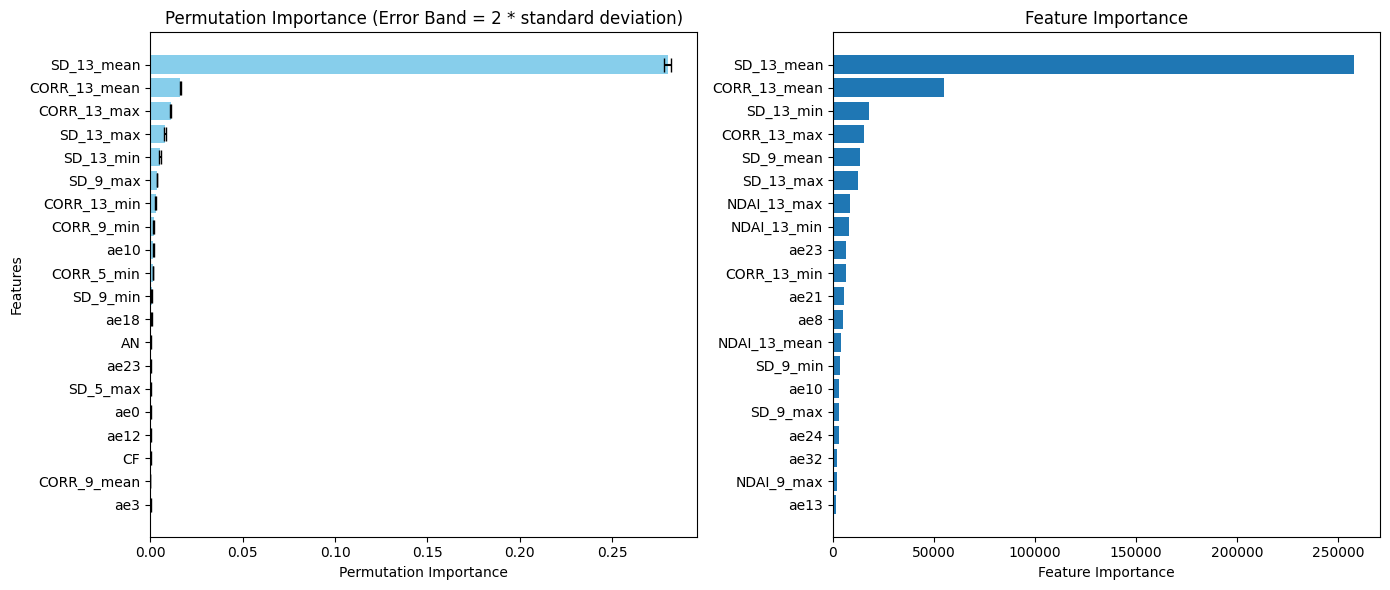

In [29]:
importance = lgb_best_model_selected.booster_.feature_importance(importance_type="gain")
feature_names = X_train_selected.columns
sorted_indices = np.argsort(importance)[-20:]

importance = importance[sorted_indices]
feature_names = feature_names[sorted_indices]

model = lgb.LGBMClassifier()
model._Booster = lgb_best_model_selected
model.fit(X_train_selected, y_train)

perm_importance = permutation_importance(model, X_test_selected, y_test, scoring="accuracy", n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:20]
perm_feature_names = X_train_selected.columns[sorted_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Permutation Importance
axes[0].barh(perm_feature_names, perm_importance.importances_mean[sorted_idx], 
             xerr=perm_importance.importances_std[sorted_idx] * 2, capsize=5, 
             color='skyblue')
axes[0].set_xlabel("Permutation Importance")
axes[0].set_ylabel("Features")
axes[0].set_title("Permutation Importance (Error Band = 2 * standard deviation)")
axes[0].invert_yaxis()

# Feature Importance
axes[1].barh(feature_names, importance)
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance")

plt.tight_layout()
plt.show()

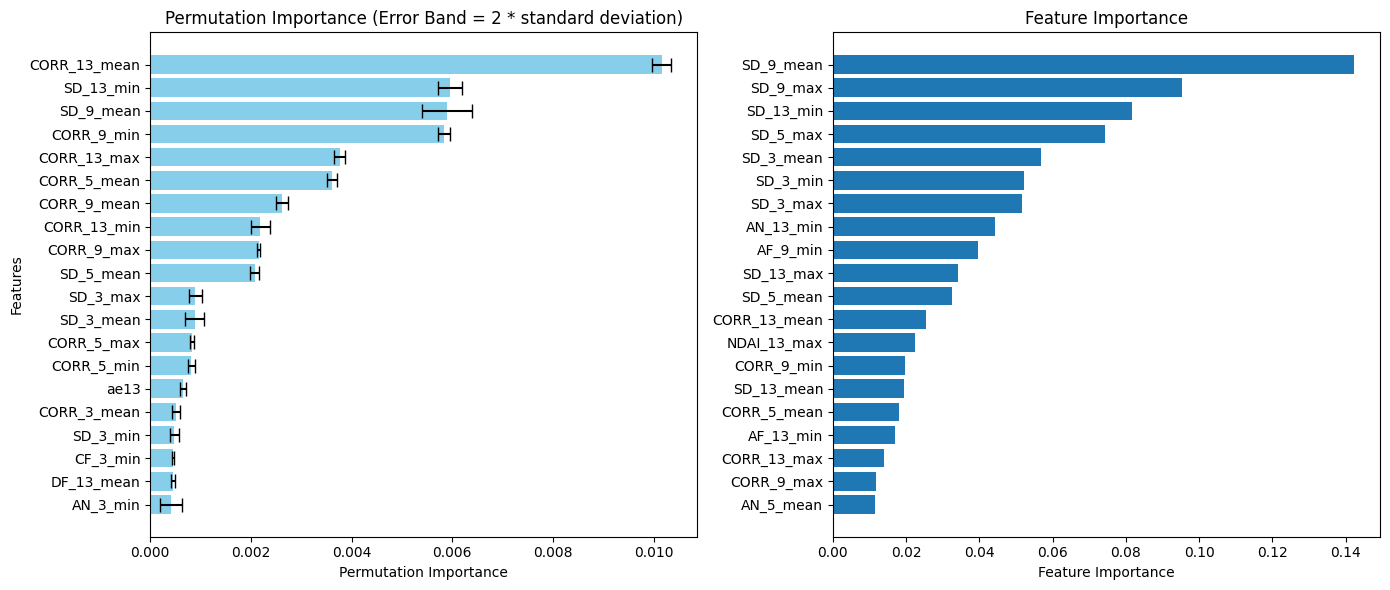

In [30]:
perm_importance_rf = permutation_importance(rf_model, X_test, y_test, scoring="accuracy", n_repeats = 5, random_state = 1)
sorted_idx_rf = perm_importance_rf.importances_mean.argsort()[::-1][:20]
perm_feature_names_rf = X_train.columns[sorted_idx_rf]

feature_importance_rf = pd.DataFrame({
    'feature': X_test.columns,
    'importance': rf_model.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)[:20]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Permutation Importance
axes[0].barh(perm_feature_names_rf, perm_importance_rf.importances_mean[sorted_idx_rf], 
             xerr=perm_importance_rf.importances_std[sorted_idx_rf] * 2, capsize=5, 
             color='skyblue')
axes[0].set_xlabel("Permutation Importance")
axes[0].set_ylabel("Features")
axes[0].set_title("Permutation Importance (Error Band = 2 * standard deviation)")
axes[0].invert_yaxis()

# Feature Importance
axes[1].barh(feature_importance_rf["feature"], feature_importance_rf["importance"])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 4-4. Perform some post-hoc EDA

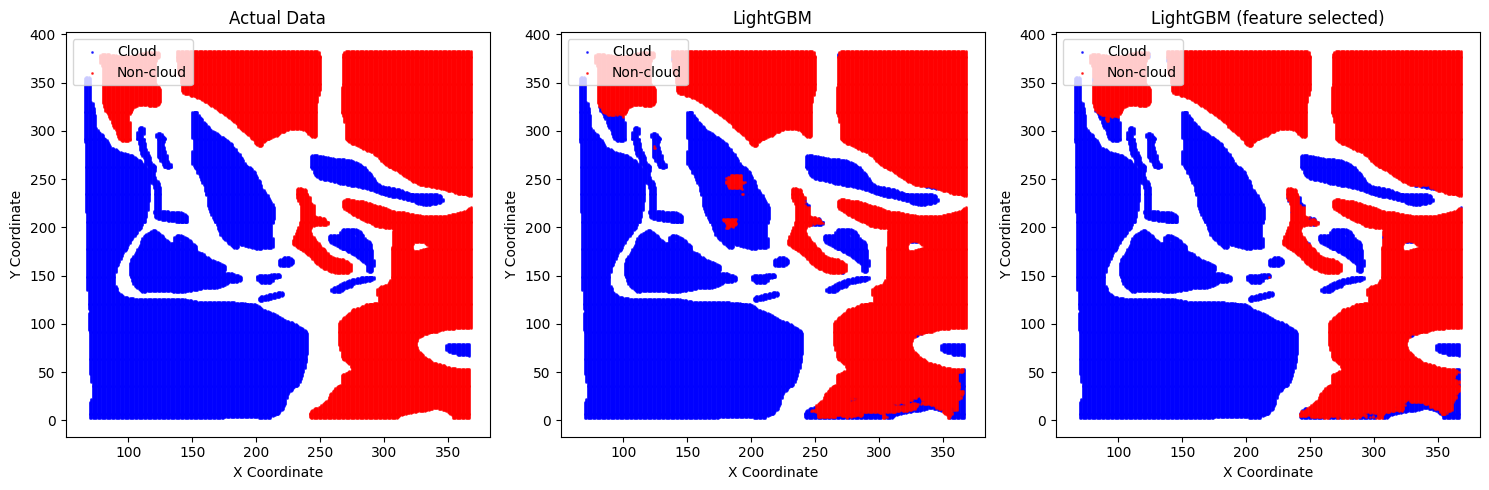

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Actual Data", "LightGBM", "LightGBM (feature selected)"]

results_test = df[df["image_id"] == "O013490.npz"]
results_test = results_test[results_test["expert_label"] != 0][['x', 'y']]
results_test['y_test'] = np.array(y_test)
results_test['y_pred'] = y_pred_lgb
results_test['y_pred_lgb'] = y_pred_lgb_selected

#creating values for the colors so 1 (cloud) is blue, 
#-1 is red (non-cloud) and 0 is grey (unlabeled)
colors = {1: 'blue', -1: 'red'} 

#open and loop through each of the 3 images
for l, ax in enumerate(axes.flat):
    #get the x coordinatee from the first column
    x = results_test['x']
    #get the y coordinate from column 0
    y = results_test['y']
    #get the expert labels from the 11th column
    labels = results_test.iloc[:,(l + 2)]
    
    #scatter plot for each image
    for i, j in colors.items():
        mask = (labels == i)
        ax.scatter(x[mask], y[mask], c=j, s=1, alpha=0.7, label='Cloud' if i == 1 else 'Non-cloud' if i == -1 else 'Unlabeled')
    
    #setting up the legend, title and labels
    if l == 0:
        ax.set_title(titles[l])
    else:
        ax.set_title(f"{titles[l]}")
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend()

plt.tight_layout()
plt.show()

### Why center part may be susceptible error?: It is because "SD_9_mean" indicates non-cloud 

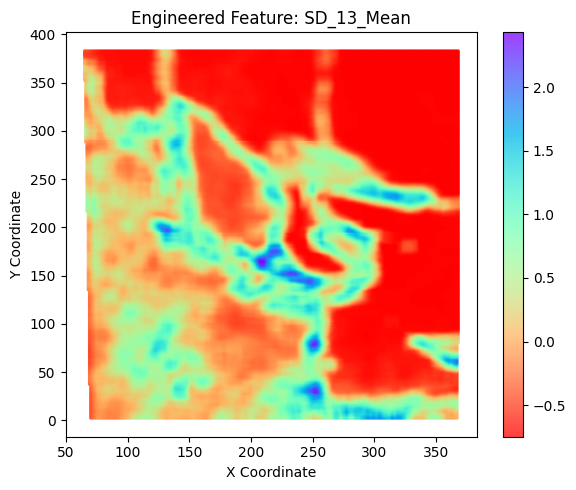

In [32]:
def visualize_feature(feature_name, df, image_id):
    fig, ax = plt.subplots(figsize=(6, 5))
    df_feature = df[df["image_id"] == image_id]

    x = np.array(df_feature["x"])
    y = np.array(df_feature["y"])
    labels = np.array(df_feature[feature_name])

    sc = ax.scatter(x, y, c = labels, s = 1, cmap='rainbow_r', alpha=0.75)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title("Engineered Feature: SD_13_Mean")
    plt.colorbar(sc)
    plt.tight_layout()
    plt.show()

visualize_feature("SD_13_mean", df, "O013490.npz")

### 4-5: Stability Analysis

### For each variable, we added normal noise with the same standard deviation as the standard deviation of each variable to 10% of the data (making the data quite noisy). However, the results were almost unchanged, suggesting that the results are robust to noise.

In [33]:
def add_noise(df, noise_ratio=0.1, random_state=42):
    np.random.seed(random_state)
    df_noisy = df.copy()
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            variance = np.var(df[col])
            std_dev = np.sqrt(variance)
            noise = np.random.normal(0, std_dev, size=len(df[col]))
            mask = np.random.rand(len(df[col])) < noise_ratio
            df_noisy.loc[mask, col] += noise[mask]
    return df_noisy

noisy_data = add_noise(X_test)

In [34]:
noisy_data = noisy_data.loc[:, ~noisy_data.columns.str.contains("AF_", case=True)]
noisy_data = noisy_data.loc[:, ~noisy_data.columns.str.contains("BF_", case=True)]
noisy_data = noisy_data.loc[:, ~noisy_data.columns.str.contains("CF_", case=True)]
noisy_data = noisy_data.loc[:, ~noisy_data.columns.str.contains("DF_", case=True)]
noisy_data = noisy_data.loc[:, ~noisy_data.columns.str.contains("AN_", case=True)]

In [35]:
y_pred_prob_noisy = lgb_best_model_selected.predict(noisy_data)
y_pred_lgb_noisy_features = (y_pred_prob_noisy > 0.5).astype(int)
y_pred_lgb_noisy_features[y_pred_lgb_noisy_features == 0] = -1

results_test = df[df["image_id"] == "O013490.npz"]
results_test = results_test[results_test["expert_label"] != 0][['x', 'y']]
results_test['y_test'] = np.array(y_test)

cm_lgb_noisy_features = confusion_matrix(y_test, y_pred_lgb_noisy_features)

results_test['y_pred_lgb_noisy_features'] = y_pred_lgb_noisy_features

### Add noise for Original Data

In [ ]:
all_files_noisy = glob.glob("../data/data_with_features_and_pca/*.csv")
df_noisy = pd.concat((pd.read_csv(f) for f in all_files_noisy), ignore_index=True)

In [37]:
df_test_noisy = df_noisy[df_noisy["image_id"] == "N013490.npz"]
df_test_noisy = df_test_noisy.drop(columns=["image_id", "y", "x"])

In [38]:
df_test_noisy = df_test_noisy.loc[:, ~df_test_noisy.columns.str.contains("AF_", case=True)]
df_test_noisy = df_test_noisy.loc[:, ~df_test_noisy.columns.str.contains("BF_", case=True)]
df_test_noisy = df_test_noisy.loc[:, ~df_test_noisy.columns.str.contains("CF_", case=True)]
df_test_noisy = df_test_noisy.loc[:, ~df_test_noisy.columns.str.contains("DF_", case=True)]
df_test_noisy = df_test_noisy.loc[:, ~df_test_noisy.columns.str.contains("AN_", case=True)]

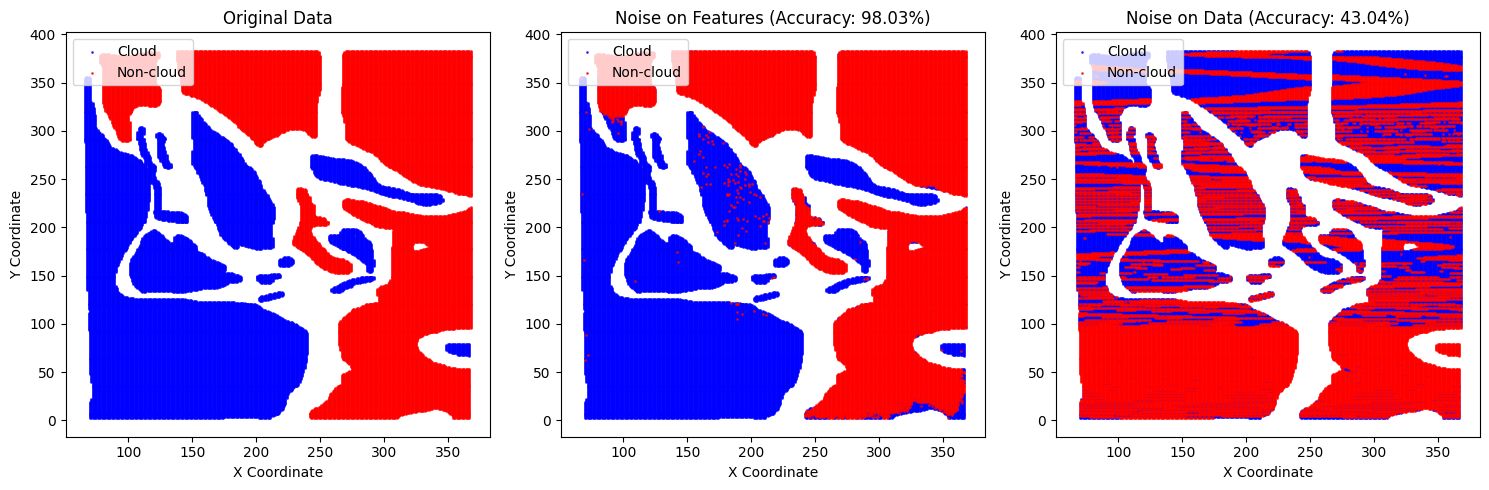

In [39]:
df_test_filtered_noisy = df_test_noisy[df_test_noisy['expert_label'] != 0]
X_test_noisy = df_test_filtered_noisy.drop(['expert_label'], axis = 1)
y_test_noisy = df_test_filtered_noisy["expert_label"]

y_pred_prob_noisy = lgb_best_model_selected.predict(X_test_noisy)
y_pred_lgb_noisy_data = (y_pred_prob_noisy > 0.5).astype(int)
y_pred_lgb_noisy_data[y_pred_lgb_noisy_data == 0] = -1

cm_lgb_noisy_data = confusion_matrix(y_test, y_pred_lgb_noisy_data)

results_test = df[df["image_id"] == "O013490.npz"]
results_test = results_test[results_test["expert_label"] != 0][['x', 'y']]
results_test['y_test'] = np.array(y_test)
results_test['y_pred_lgb_noisy_features'] = y_pred_lgb_noisy_features
results_test['y_pred_lgb_noisy_data'] = y_pred_lgb_noisy_data

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original Data", "Noise on Features",  "Noise on Data"]
cm_list = [cm_lgb_noisy_features, cm_lgb_noisy_data]

#creating values for the colors so 1 (cloud) is blue, 
#-1 is red (non-cloud) and 0 is grey (unlabeled)
colors = {1: 'blue', -1: 'red'} 

#open and loop through each of the 3 images
for l, ax in enumerate(axes.flat):
    #get the x coordinatee from the first column
    x = results_test['x']
    #get the y coordinate from column 0
    y = results_test['y']
    #get the expert labels from the 11th column
    labels = results_test.iloc[:,(l + 2)]
    
    #scatter plot for each image
    for i, j in colors.items():
        mask = (labels == i)
        ax.scatter(x[mask], y[mask], c=j, s=1, alpha=0.7, label='Cloud' if i == 1 else 'Non-cloud' if i == -1 else 'Unlabeled')
    
    #setting up the legend, title and labels
    if l == 0:
        ax.set_title(titles[l])
    else:
        accuracy = (cm_list[l-1][0, 0] + cm_list[l-1][1, 1]) / cm_list[l-1].sum()
        ax.set_title(f"{titles[l]} (Accuracy: {accuracy:.2%})")

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend(loc = "best")

plt.tight_layout()
plt.show()

### Change Test Data

In [40]:
def data_invert(test_id, df):
    df_train = df[(df["image_id"] != test_id)]
    df_test = df[df["image_id"] == test_id]
    df_train = assign_quadrants(df_train)
    df_train = df_train.drop(columns=["image_id", "y", "x"])
    df_train_filtered = df_train[df_train['expert_label'] != 0]

    df_test = df_test.drop(columns=["image_id", "y", "x"])
    df_test_filtered = df_test[df_test['expert_label'] != 0]

    X_train = df_train_filtered.drop(['expert_label', 'quadrant'], axis = 1)
    y_train = df_train_filtered["expert_label"]

    X_test = df_test_filtered.drop(['expert_label'], axis = 1)
    y_test = df_test_filtered["expert_label"]

    X_train = X_train.loc[:, ~X_train.columns.str.contains("AF_", case=True)]
    X_train = X_train.loc[:, ~X_train.columns.str.contains("BF_", case=True)]
    X_train = X_train.loc[:, ~X_train.columns.str.contains("CF_", case=True)]
    X_train = X_train.loc[:, ~X_train.columns.str.contains("DF_", case=True)]
    X_train = X_train.loc[:, ~X_train.columns.str.contains("AN_", case=True)]

    X_test = X_test.loc[:, ~X_test.columns.str.contains("AF_", case=True)]
    X_test = X_test.loc[:, ~X_test.columns.str.contains("BF_", case=True)]
    X_test = X_test.loc[:, ~X_test.columns.str.contains("CF_", case=True)]
    X_test = X_test.loc[:, ~X_test.columns.str.contains("DF_", case=True)]
    X_test = X_test.loc[:, ~X_test.columns.str.contains("AN_", case=True)]

    param_grid = {
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.05, 0.1, 0.15]
    }

    lgbm = lgb.LGBMClassifier(objective='binary', metric='accuracy', boosting_type='gbrt', verbose=-1)

    groups = df_train_filtered['quadrant']
    gkf = GroupKFold(n_splits=len(df_train_filtered['quadrant'].unique()))

    # Set up GridSearchCV with the custom group split
    grid_search = GridSearchCV(estimator=lgbm, 
                            param_grid=param_grid, 
                            cv=gkf,  # use GroupKFold here
                            n_jobs=-1,
                            verbose=1)

    grid_search.fit(X_train, y_train, groups=groups)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best AUC score: {grid_search.best_score_:.4f}")

    best_params = grid_search.best_params_

    params = {
        'objective': 'binary',
        'metric': 'accuracy',
        'boosting_type': 'gbrt',
        'verbose': -1,
    }

    params.update(best_params)

    train_data = lgb.Dataset(X_train[df_train_filtered["quadrant"] != "Q4"], 
                            label = y_train[df_train_filtered["quadrant"] != "Q4"])

    eval_data = lgb.Dataset(X_train[df_train_filtered["quadrant"] == "Q4"], 
                            label = y_train[df_train_filtered["quadrant"] == "Q4"],
                            reference = train_data)

    evals_result = {}

    lgb_best_model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=1000,
        valid_sets=[train_data, eval_data],
        valid_names=['train', 'valid'],
        callbacks=[lgb.log_evaluation(period=100)],
    )

    y_pred_prob = lgb_best_model.predict(X_test)
    y_pred_lgb = (y_pred_prob > 0.5).astype(int)
    y_pred_lgb[y_pred_lgb == 0] = -1

    cm_lgb = confusion_matrix(y_test, y_pred_lgb)
    return (cm_lgb[0, 0] + cm_lgb[1, 1]) / cm_lgb.sum()

cm_lgb_12791 = data_invert("O012791.npz", df)
cm_lgb_13257 = data_invert("O013257.npz", df)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best parameters: {'learning_rate': 0.05, 'num_leaves': 15}
Best AUC score: 0.9743
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best parameters: {'learning_rate': 0.15, 'num_leaves': 15}
Best AUC score: 0.9483


In [41]:
print(cm_lgb_12791)
print(cm_lgb_13257)

0.8590338128971007
0.9066020952757462


### Sanity Check: Predict Unlabeled Data

In [42]:
all_files = glob.glob("../data/data_with_features_and_pca_unlabeled/*.csv")

df_unlabel = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Display the first few rows of the dataframe
df_unlabel.head()

,image_id,y,x,NDAI,SD,CORR,DF,CF,BF,AF,...,ae30,ae31,ae32,ae33,ae34,ae35,ae36,ae37,ae38,ae39
0,O120437.npz,66.0,121.0,0.363061,599.563293,0.568683,19154.75,14100.75,13426.00,10216.50,...,1.342287,-1.797213,-2.801892,0.745031,-1.213778,0.467528,-1.021202,-1.517200,0.351845,0.776707
1,O120437.npz,66.0,122.0,0.358490,1527.095581,0.769741,24799.75,17710.75,15165.50,13131.00,...,0.699877,-2.030100,-3.474292,-0.748209,-1.591453,0.235449,-0.619324,-1.191846,0.293969,0.410260
2,O120437.npz,66.0,123.0,0.418869,1223.535522,0.633726,29206.00,21329.75,18031.25,14744.25,...,0.017579,-1.749286,-2.775677,-1.230728,-1.720013,0.719886,0.694641,-1.287764,0.162841,-0.214367
3,O120437.npz,66.0,124.0,0.385996,647.158875,-0.088270,27103.50,22806.00,18820.25,14616.00,...,-0.023005,-2.095482,-1.354495,-1.206701,-1.311695,1.783529,1.463743,-1.611239,0.027133,-0.147975
4,O120437.npz,66.0,125.0,0.386660,517.670959,0.002042,28033.75,23871.00,19245.00,14517.75,...,-0.030747,-2.062254,-0.126390,-1.142934,-2.016977,1.848202,1.432755,-2.113547,-0.230450,-0.738319


In [43]:
np.unique(df_unlabel["image_id"])
image_id = "O120204.npz"

In [44]:
X_test_unlabel = df_unlabel[df_unlabel["image_id"] == image_id].drop(columns=["image_id", "y", "x"])

In [45]:
X_test_unlabel_selected = X_test_unlabel.copy()
X_test_unlabel_selected = X_test_unlabel_selected.loc[:, ~X_test_unlabel_selected.columns.str.contains("AF_", case=True)]
X_test_unlabel_selected = X_test_unlabel_selected.loc[:, ~X_test_unlabel_selected.columns.str.contains("BF_", case=True)]
X_test_unlabel_selected = X_test_unlabel_selected.loc[:, ~X_test_unlabel_selected.columns.str.contains("CF_", case=True)]
X_test_unlabel_selected = X_test_unlabel_selected.loc[:, ~X_test_unlabel_selected.columns.str.contains("DF_", case=True)]
X_test_unlabel_selected = X_test_unlabel_selected.loc[:, ~X_test_unlabel_selected.columns.str.contains("AN_", case=True)]

In [46]:
y_pred_rf_unlabel = rf_model.predict(X_test_unlabel)

X_test_k_unlabel = pd.DataFrame(scaler.transform(X_test_unlabel), columns=X_test_unlabel.columns)
y_pred_knn_unlabel = best_knn.predict(X_test_k_unlabel)

y_pred_prob_unlabel = lgb_best_model_selected.predict(X_test_unlabel_selected)
y_pred_lgb_unlabel = (y_pred_prob_unlabel > 0.5).astype(int)
y_pred_lgb_unlabel[y_pred_lgb_unlabel == 0] = -1

In [47]:
results_test_unlabel = df_unlabel[df_unlabel["image_id"] == image_id][['x', 'y']]
results_test_unlabel['y_pred_rf_unlabel'] = y_pred_rf_unlabel
results_test_unlabel['y_pred_knn_unlabel'] = y_pred_knn_unlabel
results_test_unlabel['y_pred_lgb_unlabel'] = y_pred_lgb_unlabel
results_test_unlabel


,x,y,y_pred_rf_unlabel,y_pred_knn_unlabel,y_pred_lgb_unlabel
38462,62.0,2.0,1.0,1.0,1
38463,63.0,2.0,1.0,1.0,1
38464,64.0,2.0,1.0,1.0,1
38465,65.0,2.0,1.0,1.0,1
38466,66.0,2.0,1.0,1.0,1
...,...,...,...,...,...
211540,296.0,320.0,-1.0,-1.0,-1
211541,297.0,320.0,-1.0,-1.0,-1
211542,298.0,320.0,-1.0,-1.0,-1
211543,299.0,320.0,-1.0,-1.0,-1


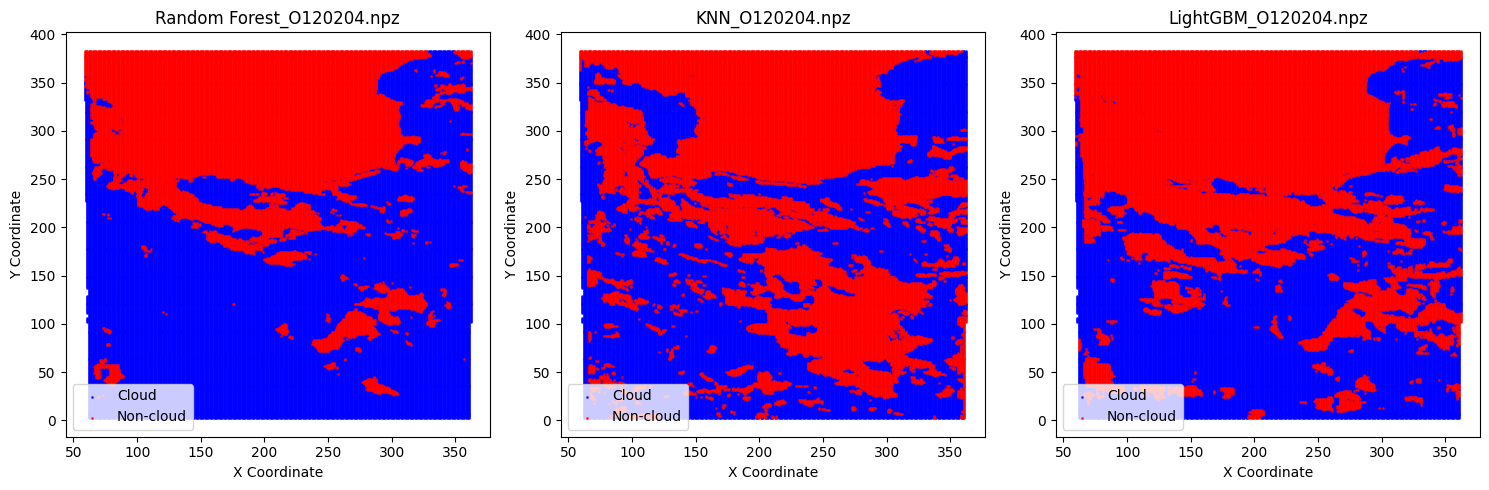

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Random Forest", "KNN", "LightGBM"]

#creating values for the colors so 1 (cloud) is blue, 
#-1 is red (non-cloud) and 0 is grey (unlabeled)
colors = {1: 'blue', -1: 'red'} 

#open and loop through each of the 3 images
for l, ax in enumerate(axes.flat):
    #get the x coordinatee from the first column
    x = results_test_unlabel['x']
    #get the y coordinate from column 0
    y = results_test_unlabel['y']
    #get the expert labels from the 11th column
    labels = results_test_unlabel.iloc[:,(l + 2)]
    
    #scatter plot for each image
    for i, j in colors.items():
        mask = (labels == i)
        ax.scatter(x[mask], y[mask], c=j, s=1, alpha=0.7, label='Cloud' if i == 1 else 'Non-cloud' if i == -1 else 'Unlabeled')
    
    #setting up the legend, title and labels
    ax.set_title(titles[l] + "_" + image_id)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend()

plt.tight_layout()
plt.show()